In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
import torch
from nltk.metrics.distance import edit_distance
from difflib import SequenceMatcher
from spellchecker import SpellChecker
from scipy.optimize import curve_fit
from string import punctuation
import nltk
nltk.download('words')

[nltk_data] Downloading package words to C:\Users\bills-fish-
[nltk_data]     shack\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [2]:
# adapted from Ruan on stackoverflow
class GPT2:
    def __init__(self):
        self.model     = GPT2LMHeadModel.from_pretrained("gpt2")
        self.tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
    
    def get_predictions(self, sentence):  # Encode the sentence using the tokenizer and return the model predictions.
        inputs = self.tokenizer.encode(sentence, return_tensors="pt")
        with torch.no_grad():
            outputs = self.model(inputs)
            predictions = outputs[0]
        return predictions
    
    def get_next_word_probabilities(self, sentence, n=50257):
        predictions = self.get_predictions(sentence)
        candidates = predictions[0, -1, :]                          # Get the next token candidates.
        topk_i = torch.topk(candidates, n).indices.tolist()         # Get the top k next token candidates.
        all_probs = torch.nn.functional.softmax(candidates, dim=-1) # Get the token probabilities for all candidates.
        topk_probs = all_probs[topk_i].tolist()                     # Filter the token probabilities for the top k candidates.
        topk_tokens = [self.tokenizer.decode([idx]).strip()         # Decode the top k candidates back to words.
                       for idx in topk_i]
        return list(zip(topk_tokens, topk_probs))
        
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()
wl       = set(nltk.corpus.words.words())
in_wl    = np.vectorize(lambda x: x in wl)
arrLower = np.vectorize(lambda x: x.lower())
spelling = SpellChecker()
model    = GPT2()

In [3]:
def rreplace(string, word, new_word):
    start = string.rfind(word)
    return string[0:start] + new_word + string[start+len(word):]

string = "when you come over can you (being)."
last_space = string.rfind(' ')
prompt = string[:last_space]
target = string[last_space+1:].strip(punctuation)
rreplace(string, 'being', 'grape')

'when you come over can you (grape).'

In [4]:
probsp = [(word, prob, similar(target, word)) for word, prob in model.get_next_word_probabilities(prompt, 5000) if word in wl]
close_probs = [prob for prob in probsp if prob[2] > 0.5 and prob[1] >= min(0.001, probsp[200][1])]
probsp[:10]

[('tell', 0.12317813187837601, 0.2222222222222222),
 ('see', 0.09064172953367233, 0.25),
 ('help', 0.0389019213616848, 0.2222222222222222),
 ('get', 0.03537685051560402, 0.25),
 ('say', 0.021695835515856743, 0.0),
 ('find', 0.01971844583749771, 0.4444444444444444),
 ('please', 0.019415108487010002, 0.18181818181818182),
 ('just', 0.01940740831196308, 0.0),
 ('hear', 0.01774522103369236, 0.2222222222222222),
 ('give', 0.017317499965429306, 0.2222222222222222)]

In [5]:
target_probs = sorted(probsp, key=lambda x: x[2], reverse=True)
if target_probs[0][2] == 1:
    target_prob = target_probs[0][1]
else:
    target_prob = 0
target_probs[:10], target_prob

([('being', 4.270836598152528e-06, 1.0),
  ('bring', 0.004747579339891672, 0.8),
  ('begin', 0.0003063126641791314, 0.8),
  ('binge', 2.877165115933167e-06, 0.8),
  ('beg', 4.08589476137422e-05, 0.75),
  ('big', 5.745548605773365e-06, 0.75),
  ('bin', 1.732433588585991e-06, 0.75),
  ('ing', 1.222215701091045e-06, 0.75),
  ('seeing', 8.778042683843523e-06, 0.7272727272727273),
  ('belong', 7.594909220642876e-06, 0.7272727272727273)],
 4.270836598152528e-06)

In [6]:
lin_map = np.vectorize(lambda x: 2*x - 1)  # allow to be applied along vectors
log_map = lambda e: np.vectorize(lambda x: np.power(np.log(x/0.5)/np.log(2), e))  # specify exponent to return vectorized mapping

In [7]:
pd.options.display.float_format = '{:,.6f}'.format
close_adj = pd.DataFrame([(word, sim, lin_map(sim), log_map(np.e)(sim), prob, 
                           prob*lin_map(sim), prob*log_map(6)(sim), (2*prob*log_map(np.e)(sim))/(prob+log_map(np.e)(sim)),
                           np.sqrt(prob*log_map(np.e)(sim))) for word, prob, sim in close_probs],
                         columns=["word", "similarity", "lin-map sim", "log-map sim", 
                                  "probability", "lin-map prob", "log-map prob", "swag",
                                  "swag2"])
close_adj["log-map sim"] = close_adj["log-map sim"].apply(pd.to_numeric)
close_adj["lin-map sim"] = close_adj["lin-map sim"].apply(pd.to_numeric)
close_adj[["word", "similarity", "log-map sim", "lin-map sim", 
           "lin-map prob", "probability", "log-map prob", "swag"]].sort_values("swag", ascending=False)

,word,similarity,log-map sim,lin-map sim,lin-map prob,probability,log-map prob,swag
1,bring,0.800000,0.347824,0.600000,0.002849,0.004748,0.000461,0.009367
0,be,0.571429,0.011370,0.142857,0.000748,0.005234,0.000000,0.007168
2,sing,0.666667,0.091591,0.333333,0.000220,0.000660,0.000003,0.001310
3,remind,0.545455,0.003549,0.090909,0.000051,0.000562,0.000000,0.000971


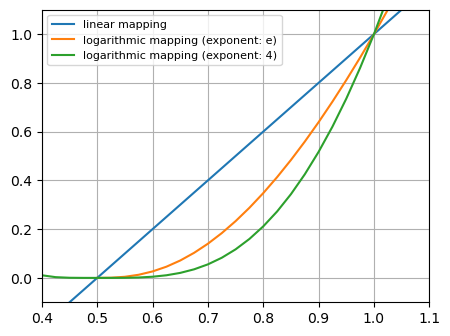

In [8]:
x = np.arange(0.4, 1.11, 0.025)
fig, ax = plt.subplots(figsize=(5,3.8))
ax.plot(x,        lin_map(x),              label='linear mapping')
#ax.plot(x,        log_map(2)(x),           label='logarithmic mapping (exponent: 2)')
ax.plot(x[4:], log_map(np.e)(x[4:]), label='logarithmic mapping (exponent: e)')  # avoid invalid outputs (x<0.5)
ax.plot(x,        log_map(4)(x),           label='logarithmic mapping (exponent: 4)')
ax.set_ylim((-0.1, 1.1))
ax.set_xlim((0.4, 1.1))
ax.legend(fontsize=8)
ax.grid()
plt.show()

In [9]:
close_adj.dtypes

word             object
similarity      float64
lin-map sim     float64
log-map sim     float64
probability     float64
lin-map prob    float64
log-map prob    float64
swag            float64
swag2           float64
dtype: object

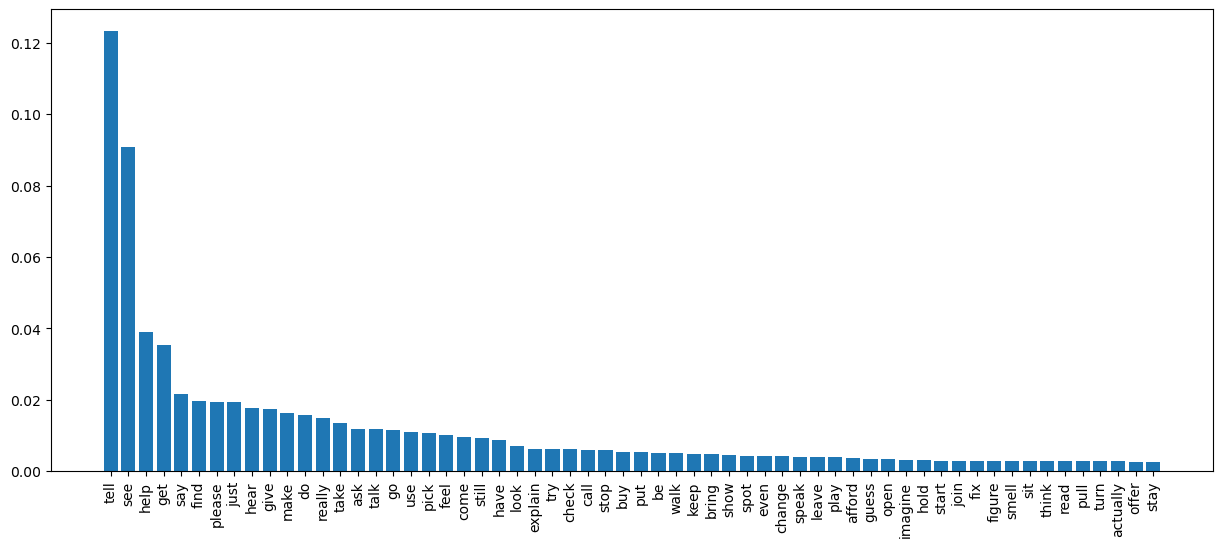

In [10]:
fig, ax = plt.subplots(figsize=(15,6))
probs_plot = np.array(probsp[:60])
ax.bar(probs_plot[:,0], probs_plot[:,1].astype(float), width=0.8)
plt.xticks(rotation=90, fontsize=10)
plt.show()

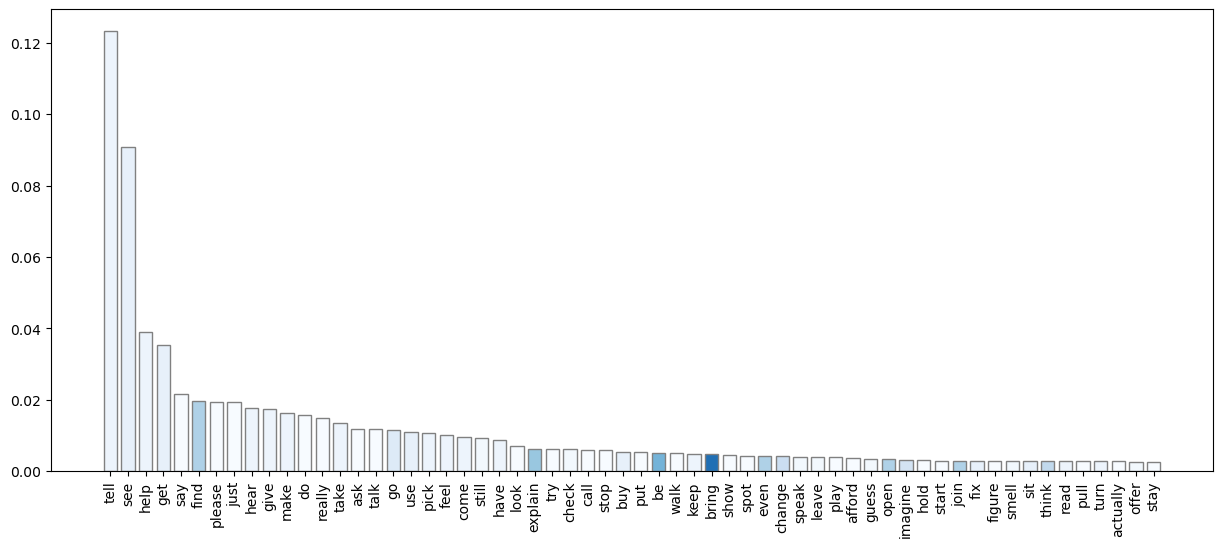

In [11]:
fig, ax = plt.subplots(figsize=(15,6))
cmap = mpl.colormaps['Blues']
norm = mpl.colors.Normalize(vmin=0.18, vmax=1.0)
ax.bar(probs_plot[:,0], probs_plot[:,1].astype(float), width=0.75, edgecolor='gray',
       color=cmap(norm(probs_plot[:,2].astype(float))))
plt.xticks(rotation=90, fontsize=10)
plt.show()

In [12]:
vals = close_adj[["word", "log-map prob"]].sort_values("log-map prob", ascending=False).values
vals

array([['bring', 0.00046145221367582996],
       ['sing', 3.373111560998804e-06],
       ['be', 2.6753356066350675e-07],
       ['remind', 2.2008698034573106e-09]], dtype=object)

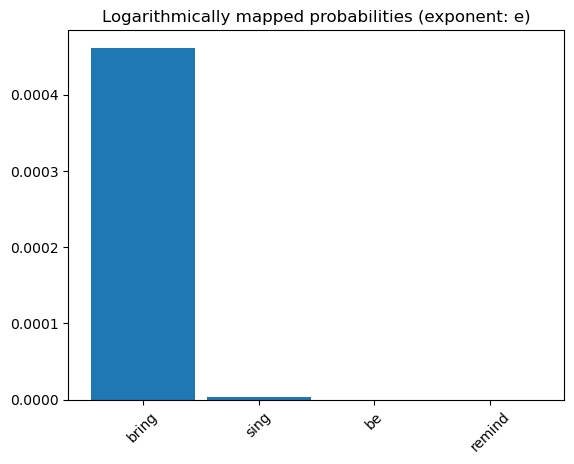

In [13]:
fig, ax = plt.subplots()
norm = mpl.colors.Normalize(vmin=np.min(vals[:,1]), vmax=np.max(vals[:,1]))
ax.bar(vals[:,0], vals[:,1], width=.9)
plt.xticks(rotation=45)
plt.title('Logarithmically mapped probabilities (exponent: e)')
plt.show()

In [14]:
f"{vals[0,1]:.6f}, {vals[1,1]:6f}"

'0.000461, 0.000003'

In [15]:
x = range(len(vals[:,1])+1)
y = list(vals[:,1])+[0]
def decay(x, a, b):
    return a * np.power(b, x)
(a, b), _ = curve_fit(decay, x, y)
vec_decay = np.vectorize(lambda x: decay(x, a, b))
b

0.007317476474902964

Curve parameter: 0.007317476474902964, intercept: 0.00046145220067202874


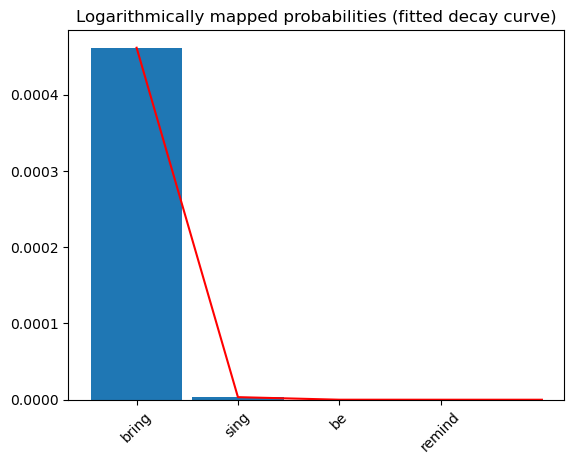

In [16]:
fig, ax = plt.subplots()
ax.bar(vals[:,0], vals[:,1], width=.9)
ax.plot(vec_decay(x), color='red')
plt.xticks(rotation=45)
plt.title('Logarithmically mapped probabilities (fitted decay curve)')
print(f"Curve parameter: {b}, intercept: {a}")
plt.show()

In [17]:
thresholdN = 200
topN       = 10
probN      = 0.0001
def correction(string):
    last_space = string.rfind(' ')
    if last_space == -1:
        if spelling.correction(string) == string:
            return None
        return spelling.correction(string)
    prompt = string[:last_space]
    target = string[last_space+1:]
    sc_target = spelling.correction(target)
    probsp = [(word, prob, similar(sc_target, word)) for word, prob in model.get_next_word_probabilities(prompt, 10000)]
    close_adj = [(word, prob*log_map(np.e)(sim)) for word, prob, sim in probsp if sim > 0.5 and prob >= min(0.001, probsp[thresholdN][1])]
    close_adj = np.array(sorted(close_adj, key=lambda x: x[1], reverse=True)[:topN])
    if len(close_adj) == 0 or sc_target.lower() in arrLower(close_adj[:,0]) or close_adj[0,1].astype(float) < probN:
        if target != sc_target:
            return sc_target
        return None
    return close_adj[0,0]

In [18]:
correction("can you really climb all the way up that birdling")

'building'